<a href="https://colab.research.google.com/github/carlibeisel/mason_water_budget/blob/main/reach_landuse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Carli Beisel

September 16, 2024

Purpose: Identify urban proportion and crop type in each reach within Mason

## Urbanization

In [ ]:
# ------------------ #
#  Import Libraries  #
# ------------------ #
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
!pip uninstall rasterio -y
! pip install rasterio==1.3.9
import rasterio
import rasterio.features
from shapely.geometry import box
from rasterio.mask import mask
from rasterio import mask
from rasterio.crs import CRS
import glob
import os
import json

#connect to google drive
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 69.6 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# --------------- #
#   Load Files    #
# --------------- #

reaches = gpd.read_file('/content/drive/MyDrive/Data/Mason Water Budget/data_input/reach_shapefile/Reaches_Final_1209/Reach_Final.shp')
cdl = rasterio.open('/content/drive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2023.tif')
irrigation_type = gpd.read_file('/content/drive/MyDrive/Data/Mason Water Budget/data_input/irrigation_runoff/irrigation_runoff.shp')

In [ ]:
# --------------- #
# Area of each reach
# --------------- #


reaches = reaches.to_crs(epsg=5070)

reaches['area_m2'] = reaches.geometry.area
reaches['area_mi2'] = reaches['area_m2'] / 2_589_988.11  # Conversion to miles

reach_areas_mi2 = reaches[['Reach', 'area_mi2']]
print("Area in square miles:")
print(reach_areas_mi2)

Area in square miles:
           Reach  area_mi2
0    Noble Drain  3.728043
1   Purdum Reach  1.693426
2  Solomon Reach  3.436166
3        Reach 1  3.898848
4        Reach 2  5.021585
5        Reach 3  0.831347


In [ ]:
## ------------------------------ ##
##  Mask CDL Layer to Each Reach  ##
## ------------------------------ ##

# Load the shapefile and raster
shapefile_path = '/content/drive/MyDrive/Data/Mason Water Budget/data_input/reach_shapefile/Reaches_Final_1209/Reach_Final.shp'
raster_path = '/content/drive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2023.tif'
output_dir = '/content/drive/MyDrive/Data/Mason Water Budget/data_input/land_cover/masked_2023'

# Read shapefile and raster
shp_file = gpd.read_file(shapefile_path)
with rasterio.open(raster_path) as src:
    print(f"Raster CRS: {src.crs}")
    print(f"Shapefile CRS: {shp_file.crs}")

    # Reproject the shapefile to match raster CRS
    shp_file = shp_file.to_crs(src.crs)

    # Explicitly use mask function
    mask_function = rasterio.mask.mask

    # Loop through each geometry and mask the raster
    for i, row in shp_file.iterrows():
        try:
            # Use geometry directly
            geometry = [row['geometry'].__geo_interface__]

            # Ensure geometry intersects the raster
            if not row['geometry'].intersects(box(*src.bounds)):
                print(f"Geometry '{row['Reach']}' does not intersect raster. Skipping...")
                continue

            # Mask raster
            out_img, out_transform = mask_function(src, shapes=geometry, crop=True, nodata=0)

            # Update metadata
            out_meta = src.meta.copy()
            out_meta.update({
                "driver": "GTiff",
                "height": out_img.shape[1],
                "width": out_img.shape[2],
                "transform": out_transform,
                "nodata": 0
            })

            # Save the masked raster
            feature_name = row['Reach']
            out_filename = os.path.join(output_dir, f"{feature_name}.tif")
            with rasterio.open(out_filename, 'w', **out_meta) as dest:
                dest.write(out_img[0], 1)

            print(f"Saved cropped raster for '{feature_name}' to {out_filename}")

        except Exception as e:
            print(f"Error processing '{row['Reach']}': {e}")

Raster CRS: EPSG:5070
Shapefile CRS: EPSG:4326
Saved cropped raster for 'Noble Drain' to /content/drive/MyDrive/Data/Mason Water Budget/data_input/land_cover/masked_2023/Noble Drain.tif
Saved cropped raster for 'Purdum Reach' to /content/drive/MyDrive/Data/Mason Water Budget/data_input/land_cover/masked_2023/Purdum Reach.tif
Saved cropped raster for 'Solomon Reach' to /content/drive/MyDrive/Data/Mason Water Budget/data_input/land_cover/masked_2023/Solomon Reach.tif
Saved cropped raster for 'Reach 1' to /content/drive/MyDrive/Data/Mason Water Budget/data_input/land_cover/masked_2023/Reach 1.tif
Saved cropped raster for 'Reach 2' to /content/drive/MyDrive/Data/Mason Water Budget/data_input/land_cover/masked_2023/Reach 2.tif
Saved cropped raster for 'Reach 3' to /content/drive/MyDrive/Data/Mason Water Budget/data_input/land_cover/masked_2023/Reach 3.tif


In [ ]:
# ---------------------------- #
#    Characterization: Urban
# ---------------------------- #

masked_cdl_dir = '/content/drive/MyDrive/Data/Mason Water Budget/data_input/land_cover/masked_2023'

# characterize urban land from cdl data
developed_crop_types = {
    82,   # developed
    121,  # openspace
    122,  # low intensity
    123,  # med intensity
    124,  # high intensity
    62,   # pasture
    176   # pasture
}

SQM_TO_SQMI = 2_589_988.11 # conversion from square meters to square miles
data = []
masked_files = glob.glob(os.path.join(masked_cdl_dir, '*.tif'))
for file_path in masked_files: # loop through each reach
    reach_name = os.path.basename(file_path).replace('.tif', '')  # extract reach name from the file name
    print(f'Processing file for reach: {reach_name}')
    with rasterio.open(file_path) as src:
        cdl_data = src.read(1)
        pixel_width = src.transform[0]   # Pixel width
        pixel_height = -src.transform[4] # Pixel height
        pixel_area = pixel_width * pixel_height  # Area of one pixel in square meters
        unique_crop_types, pixel_counts = np.unique(cdl_data, return_counts=True)

        # Initialize pixel counts
        total_pixels = 0
        developed_pixels = 0
        high_intensity_pixels = 0
        medium_intensity_pixels = 0
        low_intensity_pixels = 0
        open_space_pixels = 0
        pasture_pixels = 0

        # count pixels for each urbanization type
        for crop_type, count in zip(unique_crop_types, pixel_counts):
            total_pixels += count  # Count total number of pixels
            if crop_type in developed_crop_types:
                developed_pixels += count  # Count developed land pixels
                if crop_type == 124:  # High intensity
                    high_intensity_pixels += count
                elif crop_type == 123:  # Medium intensity
                    medium_intensity_pixels += count
                elif crop_type == 122:  # Low intensity
                    low_intensity_pixels += count
                elif crop_type == 121:  # Open space
                    open_space_pixels += count
                elif crop_type == 62: #pasture
                    pasture_pixels += count
                elif crop_type == 176: #pasture/grassland
                    pasture_pixels += count

        # Calculate areas in square meters
        total_area_m2 = total_pixels * pixel_area
        developed_area_m2 = developed_pixels * pixel_area
        high_intensity_area_m2 = high_intensity_pixels * pixel_area
        medium_intensity_area_m2 = medium_intensity_pixels * pixel_area
        low_intensity_area_m2 = low_intensity_pixels * pixel_area
        open_space_area_m2 = open_space_pixels * pixel_area
        pasture_area_m2 = pasture_pixels * pixel_area

        # Convert areas to square miles
        total_area_mi2 = total_area_m2 / SQM_TO_SQMI
        developed_area_mi2 = developed_area_m2 / SQM_TO_SQMI
        high_intensity_area_mi2 = high_intensity_area_m2 / SQM_TO_SQMI
        medium_intensity_area_mi2 = medium_intensity_area_m2 / SQM_TO_SQMI
        low_intensity_area_mi2 = low_intensity_area_m2 / SQM_TO_SQMI
        open_space_area_mi2 = open_space_area_m2 / SQM_TO_SQMI
        pasture_area_mi2 = pasture_area_m2 / SQM_TO_SQMI

        # Calculate proportion of developed land
        if total_area_mi2 > 0:
            percent_developed = 100 * (developed_area_mi2 / total_area_mi2)
        else:
            percent_developed = 0

        # Append the data for this reach
        data.append({
            'Reach': reach_name,
            'Area of Reach (mi²)': total_area_mi2,
            'Urban Land Cover Area (mi²)': developed_area_mi2,
            'High Intensity Urban (mi²)': high_intensity_area_mi2,
            'Medium Intensity Urban (mi²)': medium_intensity_area_mi2,
            'Low Intensity Urban (mi²)': low_intensity_area_mi2,
            'Open Space Urban (mi²)': open_space_area_mi2,
            'Percent of Urban Land': percent_developed,
            'Pasture (mi²)': pasture_area_mi2
        })

urban = pd.DataFrame(data)
urban
urban.to_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/land_use/urban_area.csv', index=False)

Processing file for reach: Noble Drain
Processing file for reach: Purdum Reach
Processing file for reach: Solomon Reach
Processing file for reach: Reach 1
Processing file for reach: Reach 2
Processing file for reach: Reach 3


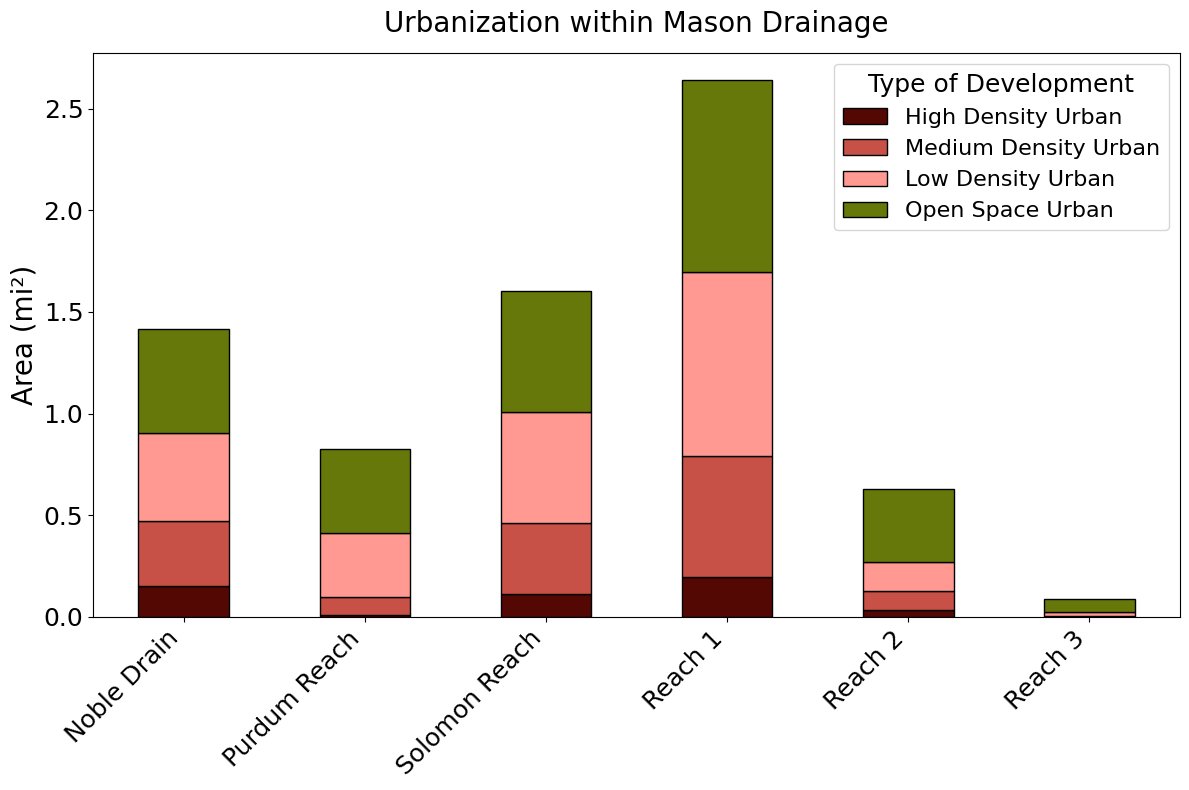

In [ ]:
# ----------------------------------------- #
# FIGURE: Type of Urbanization in each reach
# ----------------------------------------- #

plot_data = urban.set_index('Reach')

plot_data = plot_data[[
    'High Intensity Urban (mi²)',
    'Medium Intensity Urban (mi²)',
    'Low Intensity Urban (mi²)',
    'Open Space Urban (mi²)'
]]

# Rename columns to remove '(mi²)' and 'intensity' from the legend
plot_data.rename(columns=lambda x: x.replace(' (mi²)', ''), inplace=True)
plot_data.rename(columns=lambda x: x.replace('Intensity', 'Density'), inplace=True)

# custom colors for urban area
custom_colors = {
    'High Density Urban': '#540804',
    'Medium Density Urban': '#C75146',
    'Low Density Urban': '#FF9991',
    'Open Space Urban': '#67780B'
}

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
plot_data.plot(
    kind='bar',
    stacked=True,
    color=[custom_colors[col] for col in plot_data.columns],
    edgecolor='black',
    ax=ax
)
plt.title('Urbanization within Mason Drainage', fontsize=20, pad=15)
plt.ylabel('Area (mi²)', fontsize=20)
plt.xlabel('', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=18)
plt.yticks(fontsize=18)
plt.legend(
    title='Type of Development',
    loc='upper right',
    fontsize=16,
    title_fontsize=18
)
plt.tight_layout()

plt.show()
plt.savefig('/content/drive/MyDrive/Data/Mason Water Budget/data_output/land_use/Figures/urbanization.png', dpi=300, bbox_inches='tight')
plt.close()

## Crops, pasture, and uran


Crop keys to combine: {1, 12, 13, 14, 21, 22, 23, 24, 26, 27, 28, 29, 36, 37, 39, 41, 47, 49, 51, 52, 53, 54, 55, 57, 61, 68, 69, 72, 77, 205, 206, 207, 208, 209, 210, 212, 214, 216, 217, 218, 219, 220, 221, 222, 223, 225, 226, 228, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 243, 244, 245, 246, 247, 248, 249, 250, 254}
Processing file for reach: Noble Drain
Processing file for reach: Purdum Reach
Processing file for reach: Solomon Reach
Processing file for reach: Reach 1
Processing file for reach: Reach 2
Processing file for reach: Reach 3


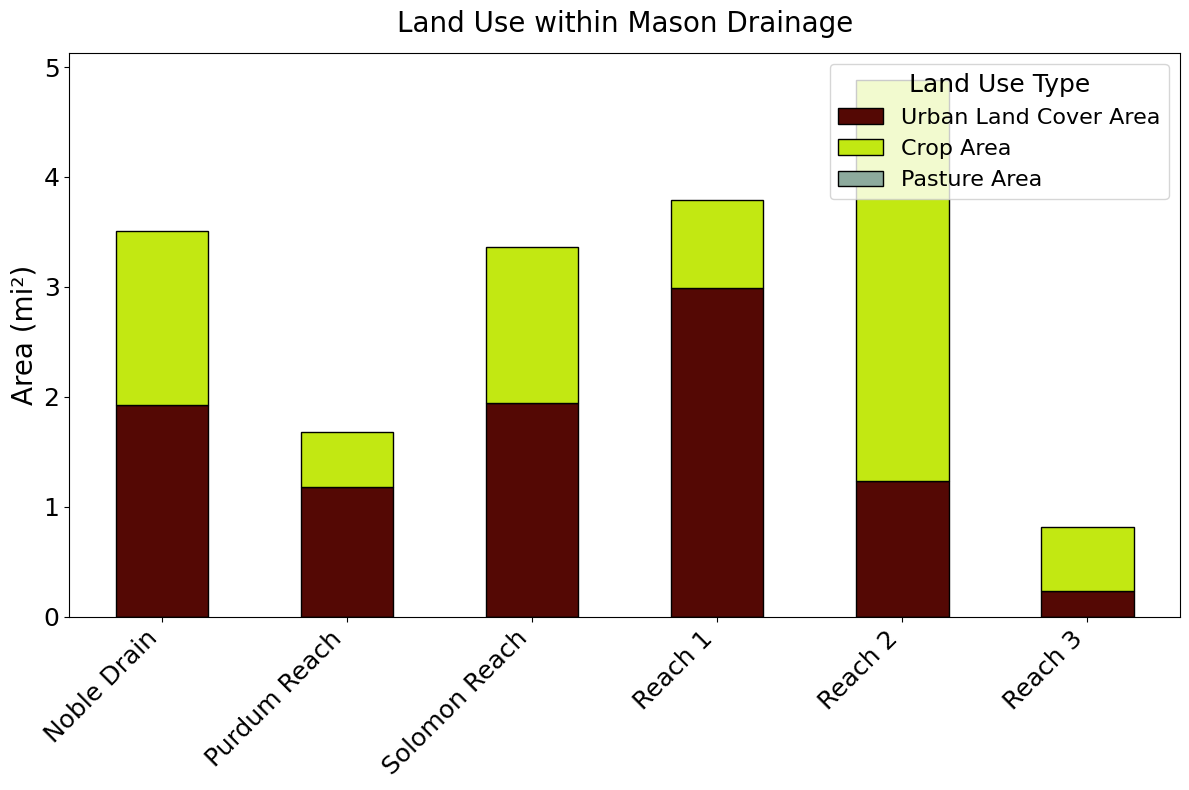

In [ ]:
## Crops, Pasture, and Urban

crop_types = {
    1:'Corn',
    2:'Cotton',
    3:'Rice',
    4:'Sorghum',
    5:'Soybeans',
    6:'Sunflower',
    10:'Peanuts',
    11:'Tobacco',
    12:'Corn',
    13:'Corn',
    14:'Mint',
    21:'Wheat',
    22:'Wheat',
    23:'Wheat',
    24:'Wheat',
    25:'Other Small Grains',
    26:'Double Crop',
    27:'Wheat',
    28:'Wheat',
    29:'Wheat',
    30:'Speltz',
    31:'Canola',
    32:'Flaxseed',
    33:'Safflower',
    34:'Brassica napus',
    35:'Mustard',
    36:'Wheat',
    37:'Wheat',
    38:'Camelina',
    39:'Wheat',
    41:'Sugarbeets',
    46:'Sweet Potatoes', #change to veggies/fruit?
    47:'Vegetables/Fruit',
    48:'Other',
    49:'Onions',
    50:'Other',
    51:'Dry Beans',
    52:'Dry Beans',
    53:'Peas',
    54:'Vegetables/Fruit',
    55:'Vegetables/Fruit',
    56:'Hops',
    57:'Herbs',
    58:'Clover/Wildflowers',
    59:'Pasture',
    60:'Switchgrass',
    61:'Fallow/Idle Cropland',
    62:'Pasture',
    63:'Forest',
    64:'Shrubland',
    65:'Barren',
    66:'Cherries',
    67:'Peaches',
    68:'Vegetables/Fruit',
    69:'Vegetables/Fruit',
    70:'Christmas Trees',
    71:'Other Tree Crops',
    72:'Vegetables/Fruit',
    74:'Pecans',
    75:'Almonds',
    76:'Walnuts',
    77:'Vegetables/Fruit',
    81:'Clouds/No Data',
    82:'Developed',
    83:'Water',
    87:'Wetlands',
    88:'Nonag/Undefined',
    92:'Aquaculture',
    111:'Open Water',
    112:'Perennial Ice/Snow',
    121:'Developed/Open Space',
    122:'Developed', #Low Intensity
    123:'Developed', #Med Intensity
    124:'Developed', #High Intensity
    131:'Barren',
    141:'Deciduous Forest',
    142:'Evergreen Forest',
    143:'Mixed Forest',
    152:'Shrubland',
    176:'Pasture',
    190:'Woody Wetlands',
    195:'Shrubland',
    204:'Pistachios',
    205:'Wheat',
    206:'Vegetables/Fruit',
    207:'Vegetables/Fruit',
    208:'Vegetables/Fruit',
    209:'Vegetables/Fruit',
    210:'Vegetables/Fruit',
    211:'Olives',
    212:'Vegetables/Fruit',
    213:'Honeydew Melons',
    214:'Vegetables/Fruit',
    215:'Avocados',
    216:'Vegetables/Fruit',
    217:'Vegetables/Fruit',
    218:'Vegetables/Fruit',
    219:'Greens',
    220:'Vegetables/Fruit',
    221:'Vegetables/Fruit',
    222:'Vegetables/Fruit',
    223:'Vegetables/Fruit',
    224:'Vetch',
    225:'Double Crop',
    226:'Double Crop',
    227:'Lettuce',
    228:'Double Crop',
    229:'Pumpkins',
    230:'Double Crop', #Lettuce/Durum Wht
    231:'Double Crop', #Lettuce/Cantaloupe
    232:'Double Crop', #Lettuce/Cotton
    233:'Double Crop', #Lettuce/Barley
    234:'Double Crop', #Durum Wht/Sorghum
    235:'Double Crop', #Barley/Sorghum
    236:'Double Crop', #WinWht/Sorghum
    237:'Double Crop', #Barley/Corn
    238:'Double Crop', #WinWht/Cotton
    239:'Double Crop', #Soybeans/Cotton
    240:'Double Crop', #Soybeans/Oats
    241:'Double Crop', #Corn/Soybeans
    242:'Blueberries',
    243:'Vegetables/Fruit',
    244:'Vegetables/Fruit',
    245:'Vegetables/Fruit',
    246:'Vegetables/Fruit',
    247:'Vegetables/Fruit',
    248:'Vegetables/Fruit',
    249:'Vegetables/Fruit',
    250:'Vegetables/Fruit',
    254:'Double Crop'}
# Provided crops to combine
crops_to_combine = [
    "Corn", "Dry Beans", "Greens", "Mint", "Fallow/Idle Cropland",
    "Sugar Crop", "Onions", "Herb", "Peas", "Herbs", "Turnips",
    "Sugarbeets", "Carrots", "Potatoes", "Double Crop", "Vegetables/Fruit", "Wheat"
]

# Extract keys for the specified crops
crops_to_combine_keys = {key for key, value in crop_types.items() if value in crops_to_combine}
print("Crop keys to combine:", crops_to_combine_keys)
SQM_TO_SQMI = 2_589_988.11

data = []
masked_files = glob.glob(os.path.join(masked_cdl_dir, '*.tif'))
for file_path in masked_files:
    reach_name = os.path.basename(file_path).replace('.tif', '')  # Extract reach name
    print(f'Processing file for reach: {reach_name}')
    with rasterio.open(file_path) as src:
        cdl_data = src.read(1)
        pixel_width = src.transform[0]
        pixel_height = -src.transform[4]
        pixel_area = pixel_width * pixel_height
        unique_crop_types, pixel_counts = np.unique(cdl_data, return_counts=True)

        # Initialize pixel counts
        total_pixels = 0
        developed_pixels = 0
        crop_pixels = 0
        pasture_pixels = 0

        # Count pixels for each land cover type
        for crop_type, count in zip(unique_crop_types, pixel_counts):
            total_pixels += count
            if crop_type in developed_crop_types:
                developed_pixels += count
            elif crop_type in crops_to_combine_keys:
                crop_pixels += count
            elif crop_type in {62, 176}:  # Pasture
                pasture_pixels += count

        # Calculate areas in square meters
        total_area_m2 = total_pixels * pixel_area
        developed_area_m2 = developed_pixels * pixel_area
        crop_area_m2 = crop_pixels * pixel_area
        pasture_area_m2 = pasture_pixels * pixel_area

        # Convert to square miles
        total_area_mi2 = total_area_m2 / SQM_TO_SQMI
        developed_area_mi2 = developed_area_m2 / SQM_TO_SQMI
        crop_area_mi2 = crop_area_m2 / SQM_TO_SQMI
        pasture_area_mi2 = pasture_area_m2 / SQM_TO_SQMI

        # Calculate proportions
        percent_developed = (developed_area_mi2 / total_area_mi2) * 100 if total_area_mi2 > 0 else 0
        percent_crops = (crop_area_mi2 / total_area_mi2) * 100 if total_area_mi2 > 0 else 0
        percent_pasture = (pasture_area_mi2 / total_area_mi2) * 100 if total_area_mi2 > 0 else 0

        # Append data
        data.append({
            'Reach': reach_name,
            'Area of Reach (mi²)': total_area_mi2,
            'Urban Land Cover Area (mi²)': developed_area_mi2,
            'Percent of Urban Land': percent_developed,
            'Crop Area (mi²)': crop_area_mi2,
            'Percent of Crop Land': percent_crops,
            'Pasture Area (mi²)': pasture_area_mi2,
            'Percent of Pasture Land': percent_pasture
        })

urban_crops_pasture = pd.DataFrame(data)
# Plot stacked bar plot for Urban, Crops, and Pasture
plot_data = urban_crops_pasture.set_index('Reach')

# Select relevant columns for the plot
plot_data = plot_data[[
    'Urban Land Cover Area (mi²)',
    'Crop Area (mi²)',
    'Pasture Area (mi²)'
]]

# Rename columns to remove '(mi²)' from the legend
plot_data.rename(columns=lambda x: x.replace(' (mi²)', ''), inplace=True)

# Custom colors for the plot
custom_colors = {
    'Urban Land Cover Area': '#540804',  # Dark red for urban
    'Crop Area': '#C2E812',             # Bright green for crops
    'Pasture Area': '#8DAA9D'           # Soft green for pasture
}

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
plot_data.plot(
    kind='bar',
    stacked=True,
    color=[custom_colors[col] for col in plot_data.columns],
    edgecolor='black',
    ax=ax
)
plt.title('Land Use within Mason Drainage', fontsize=20, pad=15)
plt.ylabel('Area (mi²)', fontsize=20)
plt.xlabel('', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=18)
plt.yticks(fontsize=18)
plt.legend(
    title='Land Use Type',
    loc='upper right',
    fontsize=16,
    title_fontsize=18
)
plt.tight_layout()

plt.show()


## Irrigation Type


In [ ]:
# ------------------ #
#  Import Libraries  #
# ------------------ #
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

#connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# --------------- #
#   Load Files    #
# --------------- #
reaches = gpd.read_file('/content/drive/MyDrive/Data/Mason Water Budget/data_input/reach_shapefile/Reaches_Final_1209/Reach_Final.shp')

urban = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/land_use/urban_area.csv')

# FWT shapefile of irrigation type based on ML, satellite imagery, & OpenET
irrigation_type = gpd.read_file('/content/drive/MyDrive/Data/Mason Water Budget/data_input/irrigation_runoff/irrigation_runoff.shp')

In [ ]:
# ----------------------------------- #
#   Irrigation Type for each Reach    #
# ----------------------------------- #

# Reproject the irrigation shapefile to match the CRS of the reaches shapefile
irrigation_type = irrigation_type.to_crs(reaches.crs)

# Perform the intersection between reaches and irrigation type geometries
intersection = gpd.overlay(reaches, irrigation_type, how='intersection')

# Calculate the area of each intersected polygon in square meters using the geometry column
intersection['area_m2'] = intersection.geometry.area

# Conversion factor from square meters to square miles
SQM_TO_SQMI = 2_589_988.11

# Convert the area to square miles
intersection['area_mi2'] = intersection['area_m2'] / SQM_TO_SQMI

# Group by reach and irrigation type to calculate the total area of each irrigation type per reach
irrigation_areas_by_reach = intersection.groupby(['Reach', 'irr_type_y'])['area_mi2'].sum().reset_index()

# Create a pivot table to get the irrigation type areas for each reach
irrig_type = irrigation_areas_by_reach.pivot(index='Reach', columns='irr_type_y', values='area_mi2').fillna(0)

# Calculate the total irrigated area (in square miles) for each reach
irrig_type['Total Irrigated Area (mi²)'] = irrig_type.sum(axis=1)

# rename the 'Name' column to 'Reach'
irrig_type = irrig_type.reset_index()
irrig_type

<ipython-input-21-0aa14ed6ed07>:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  intersection['area_m2'] = intersection.geometry.area


irr_type_y,Reach,Flood,Not Irrigated,Sprinkler,Total Irrigated Area (mi²)
0,Noble Drain,1.312009e-09,4.146104e-11,1.381897e-10,1.491660e-09
1,Purdum Reach,3.998893e-10,0.000000e+00,0.000000e+00,3.998893e-10
2,Reach 1,7.615078e-10,4.481768e-11,9.274360e-11,8.990691e-10
3,Reach 2,4.452460e-09,2.787556e-11,2.799733e-11,4.508333e-09
4,Reach 3,6.816916e-10,1.808205e-11,1.886915e-11,7.186428e-10
5,Solomon Reach,1.331176e-09,2.496317e-11,4.488151e-11,1.401021e-09


In [ ]:
# Conversion factor from square meters to square miles
SQM_TO_SQMI = 2_589_988.11

# Reproject and validate data
projected_crs = "EPSG:5070"

# Reproject reaches and irrigation_type to a projected CRS
if reaches.crs != projected_crs:
    reaches = reaches.to_crs(projected_crs)
if irrigation_type.crs != projected_crs:
    irrigation_type = irrigation_type.to_crs(projected_crs)

# Clean and dissolve irrigation geometries by type to remove overlaps
irrigation_type = irrigation_type.dissolve(by='irr_type_y').reset_index()

# Perform intersection between reaches and irrigation type geometries
intersection = gpd.overlay(reaches, irrigation_type, how='intersection')

# Ensure no duplicate overlaps
intersection = intersection.drop_duplicates(subset=['geometry'])

# Calculate the area of each intersected polygon in square meters
intersection['area_m2'] = intersection.geometry.area

# Convert area to square miles
intersection['area_mi2'] = intersection['area_m2'] / SQM_TO_SQMI

# Group by Reach and irrigation type to calculate total area
irrigation_areas_by_reach = (
    intersection.groupby(['Reach', 'irr_type_y'])['area_mi2']
    .sum()
    .reset_index()
)

# Ensure total area does not exceed the reach area
# Calculate total area per reach
total_reach_areas = reaches.copy()
total_reach_areas['area_m2'] = total_reach_areas.geometry.area
total_reach_areas['area_mi2'] = total_reach_areas['area_m2'] / SQM_TO_SQMI

# Merge total reach areas with irrigation data
irrigation_areas_by_reach = irrigation_areas_by_reach.merge(
    total_reach_areas[['Reach', 'area_mi2']],
    on='Reach',
    suffixes=('', '_total')
)

# Normalize irrigation areas if they exceed the total reach area
irrigation_areas_by_reach['normalized_area_mi2'] = (
    irrigation_areas_by_reach.groupby('Reach')['area_mi2']
    .transform(lambda x: x / x.sum() * irrigation_areas_by_reach['area_mi2_total'])
)

# Pivot table for final output
irrig_type = irrigation_areas_by_reach.pivot(
    index='Reach', columns='irr_type_y', values='normalized_area_mi2'
).fillna(0)

# Add total irrigated area
irrig_type['Total Irrigated Area (mi²)'] = irrig_type.sum(axis=1)

# Reset index and display
irrig_type = irrig_type.reset_index()
print(irrig_type)

irr_type_y          Reach     Flood  Not Irrigated  Sprinkler  \
0             Noble Drain  3.278984       0.103564   0.345494   
1            Purdum Reach  1.693426       0.000000   0.000000   
2                 Reach 1  3.302244       0.194360   0.402244   
3                 Reach 2  4.959361       0.031048   0.031177   
4                 Reach 3  0.788603       0.020917   0.021827   
5           Solomon Reach  3.264956       0.061198   0.110011   

irr_type_y  Total Irrigated Area (mi²)  
0                             3.728043  
1                             1.693426  
2                             3.898848  
3                             5.021585  
4                             0.831347  
5                             3.436166  


In [ ]:
# -------------------------- #
## Combine Data & Load File
# -------------------------- #

# Combine the two data frame
land_use = pd.merge(urban, irrig_type, on='Reach', how='left')
land_use.to_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/land_use/land_use.csv', index=False)

file = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/land_use/land_use.csv')
file

,Reach,Area of Reach (mi²),Urban Land Cover Area (mi²),High Intensity Urban (mi²),Medium Intensity Urban (mi²),Low Intensity Urban (mi²),Open Space Urban (mi²),Percent of Urban Land,Pasture (mi²),Flood,Not Irrigated,Sprinkler,Total Irrigated Area (mi²)
0,Noble Drain,14.714199,1.923715,0.149769,0.320735,0.432280,0.511161,13.073871,0.509771,3.278984,0.103564,0.345494,3.728043
1,Purdum Reach,6.222886,1.175913,0.007297,0.089653,0.316218,0.409693,18.896583,0.353052,1.693426,0.000000,0.000000,1.693426
2,Solomon Reach,12.336659,1.940395,0.108765,0.351314,0.546952,0.593864,15.728691,0.339500,3.264956,0.061198,0.110011,3.436166
3,Reach 1,8.567761,2.985651,0.196680,0.594906,0.903827,0.948653,34.847502,0.341585,3.302244,0.194360,0.402244,3.898848
4,Reach 2,13.301992,1.231164,0.030927,0.095560,0.144557,0.356179,9.255486,0.603941,4.959361,0.031048,0.031177,5.021585
5,Reach 3,1.990086,0.228302,0.000000,0.001390,0.021197,0.063939,11.471975,0.141777,0.788603,0.020917,0.021827,0.831347


## Stacked Bar Plot of Urban + Irrig Type for Each Reach

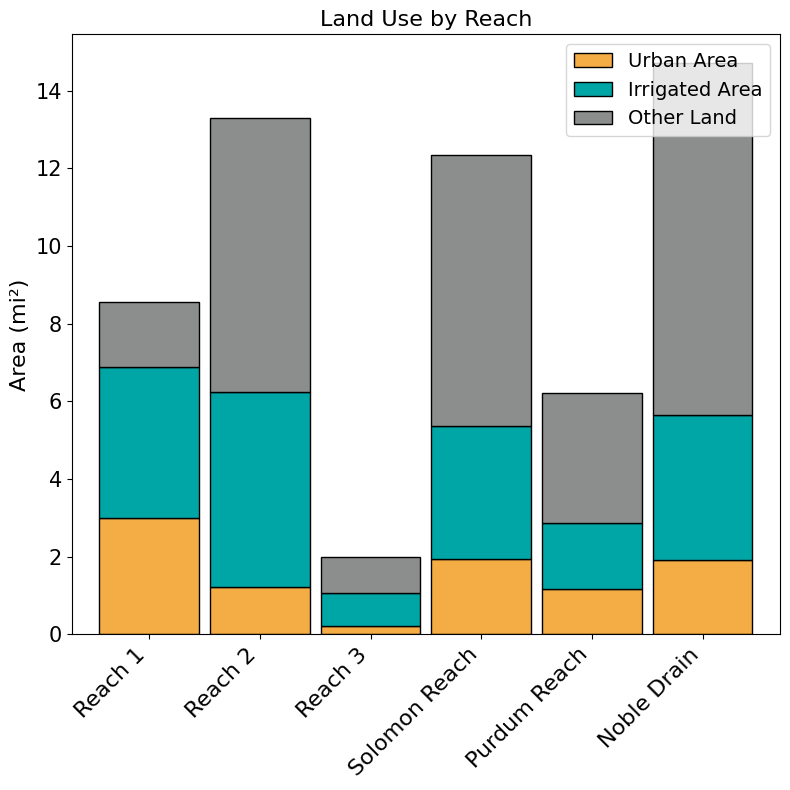

In [ ]:
## ------- ##
#   Figure: AG/Urban land
## ------- ##
# Load the data
file = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/land_use/land_use.csv')

# Define custom order for the reaches
custom_order = ['Reach 1', 'Reach 2', 'Reach 3', 'Solomon Reach', 'Purdum Reach', 'Noble Drain']
file = file.set_index('Reach').loc[custom_order]

# Calculate "Other Land Area" (difference between total area and sum of urban + irrigated areas)
file['Other Land Area (mi²)'] = file['Area of Reach (mi²)'] - file['Urban Land Cover Area (mi²)'] - file['Total Irrigated Area (mi²)']

# Ensure no negative values due to rounding or data issues
file['Other Land Area (mi²)'] = file['Other Land Area (mi²)'].clip(lower=0)

# Define custom colors
custom_colors = ['#F4AC45', '#00A6A6', '#8C8D8D']  # Urban, Irrigated, Other

# Plot the stacked bar chart
fig, ax = plt.subplots(figsize=(8, 8))
file[['Urban Land Cover Area (mi²)', 'Total Irrigated Area (mi²)', 'Other Land Area (mi²)']].plot(
    kind='bar',
    stacked=True,
    ax=ax,
    width=0.9,
    color=custom_colors,
    edgecolor='black'
)

# Customize the plot
ax.set_xlabel('', fontsize=16)
ax.set_ylabel('Area (mi²)', fontsize=16)
ax.set_title('Land Use by Reach', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.yticks(fontsize=15)

# Adjust the legend
legend_labels = ['Urban Area', 'Irrigated Area', 'Other Land']
plt.legend(legend_labels, loc="upper right", bbox_to_anchor=(1, 1), fontsize=14)

# Finalize layout
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Carli Thesis/Figures/Water Budget/reach_land_use.png', dpi=300, bbox_inches='tight')
plt.show()

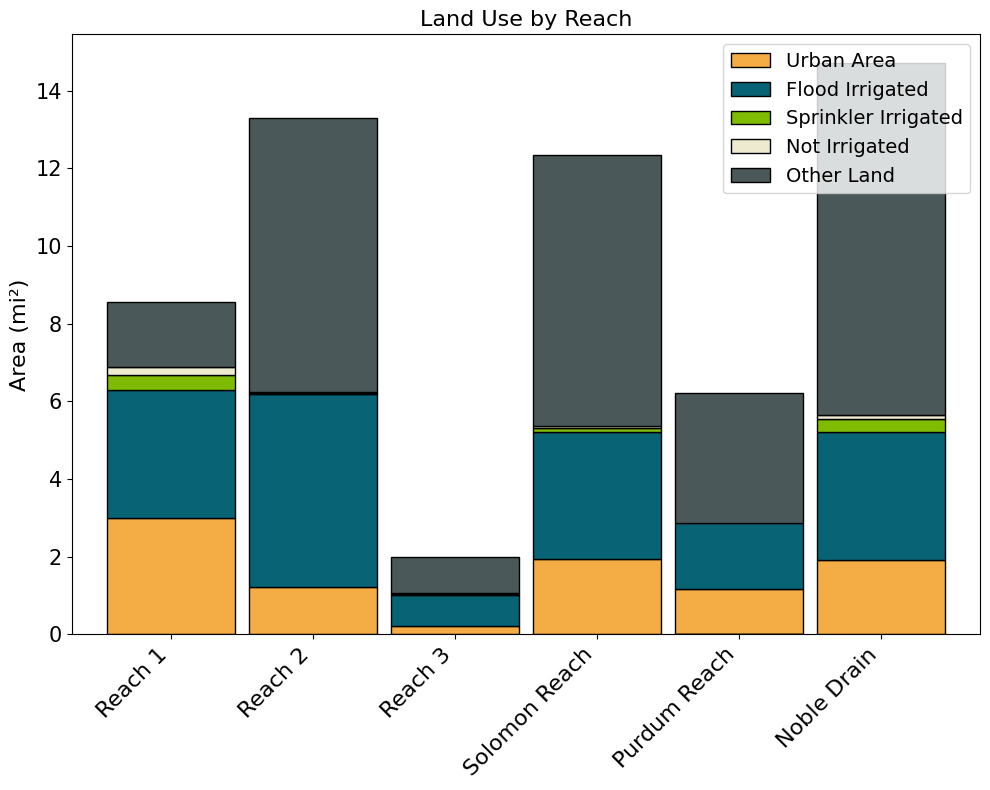

In [ ]:
## ------- ##
#   Figure: Urban land + Type of Irrigation
## ------- ##

# Load the data
file = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/land_use/land_use.csv')

# Define custom order for the reaches
custom_order = ['Reach 1', 'Reach 2', 'Reach 3', 'Solomon Reach', 'Purdum Reach', 'Noble Drain']
file = file.set_index('Reach').loc[custom_order]

# Calculate "Other Land Area" (difference between total area and the sum of other categories)
file['Other Land Area (mi²)'] = (
    file['Area of Reach (mi²)']
    - file['Urban Land Cover Area (mi²)']
    - file['Flood']
    - file['Sprinkler']
    - file['Not Irrigated']
)

# Ensure no negative values due to rounding or data issues
file['Other Land Area (mi²)'] = file['Other Land Area (mi²)'].clip(lower=0)

# Define custom colors for each category
custom_colors = ['#F4AC45', '#086375', '#7FBB00', '#EDEAD0', '#4A5859']  # Urban, Flood, Sprinkler, Not Irrigated, Other

# Plot the stacked bar chart
fig, ax = plt.subplots(figsize=(10, 8))
file[['Urban Land Cover Area (mi²)', 'Flood', 'Sprinkler', 'Not Irrigated', 'Other Land Area (mi²)']].plot(
    kind='bar',
    stacked=True,
    ax=ax,
    width=0.9,
    color=custom_colors,
    edgecolor='black'
)

# Customize the plot
ax.set_xlabel('', fontsize=16)
ax.set_ylabel('Area (mi²)', fontsize=16)
ax.set_title('Land Use by Reach', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.yticks(fontsize=15)

# Adjust the legend
legend_labels = ['Urban Area', 'Flood Irrigated', 'Sprinkler Irrigated', 'Not Irrigated', 'Other Land']
plt.legend(legend_labels, loc="upper right", bbox_to_anchor=(1, 1), fontsize=14)

# Finalize layout
plt.tight_layout()
#plt.savefig('/content/drive/MyDrive/Carli Thesis/Figures/Water Budget/reach_land_use_updated.png', dpi=300, bbox_inches='tight')
plt.show()

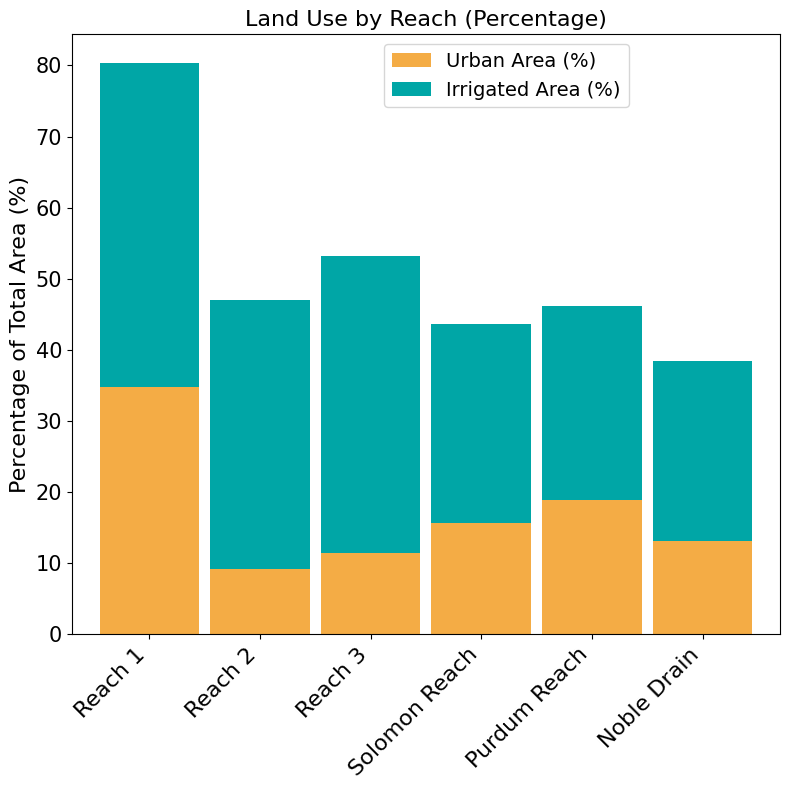

In [ ]:
## ------- ##
#   Figure: AG/Urban land %
## ------- ##

file = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/land_use/land_use.csv')

# Define the custom order for the reaches
custom_order = ['Reach 1', 'Reach 2', 'Reach 3', 'Solomon Reach', 'Purdum Reach', 'Noble Drain']

# Set the index to the 'Reach' column and reorder the rows according to custom_order
file = file.set_index('Reach').loc[custom_order]

# Calculate the percentage of each land use category relative to the total area of each reach
file['Urban %'] = (file['Urban Land Cover Area (mi²)'] / file['Area of Reach (mi²)']) * 100
file['Irrigated %'] = (file['Total Irrigated Area (mi²)'] / file['Area of Reach (mi²)']) * 100

# Define custom colors for the plot
custom_colors = ['#F4AC45', '#00A6A6']

# Create the plot
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the percentage of urban and irrigated areas
file[['Urban %', 'Irrigated %']].plot(
    kind='bar', stacked=True, ax=ax, width=0.9, color=custom_colors)

# Customize the plot appearance
ax.set_xlabel('', fontsize=16)
ax.set_ylabel('Percentage of Total Area (%)', fontsize=16)
ax.set_title('Land Use by Reach (Percentage)', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.yticks(fontsize=15)

# Adjust legend and save the plot
legend_labels = ['Urban Area (%)', 'Irrigated Area (%)']
plt.legend(legend_labels, loc="upper right", bbox_to_anchor=(0.8, 1), fontsize=14)
plt.tight_layout()
#plt.savefig('/content/drive/MyDrive/Carli Thesis/Figures/Water Budget/reach_land_use_percentage.png', dpi=300, bbox_inches='tight')
plt.show()

## Urbanization over time from 2013 to 2023


In [3]:
## IMPORT PACKAGES ##

# Import necessary libraries
import glob
import os
import numpy as np
import pandas as pd
import geopandas as gpd
! pip install rasterio
import rasterio
from rasterio.mask import mask
from shapely.geometry import box
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 45.7 MB/s eta 0:00:00
Mounted at /content/gdrive


In [4]:
# Mask CDL data to Mason Watershed boundary
shapefile_path = '/content/gdrive/MyDrive/Data/Mason Water Budget/data_input/Mason WDB/Mason Creek WDB.shp'
raster_dir = '/content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl'
output_dir = '/content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked'

# Read the shapefile
shp_file = gpd.read_file(shapefile_path)
print(f"Original shapefile CRS: {shp_file.crs}")


# Iterate through all raster files in the raster directory
for raster_path in glob.glob(os.path.join(raster_dir, '*.tif')):
    print(f"Processing raster: {raster_path}")

    # Open the raster
    with rasterio.open(raster_path) as src:
        print(f"Raster CRS: {src.crs}")
        print(f"Raster bounds: {src.bounds}")

        # Reproject the shapefile to match raster CRS
        shp_file = shp_file.to_crs(src.crs)
        print(f"Reprojected shapefile bounds: {shp_file.total_bounds}")

        # Combine all geometries into a single outline
        shp_outline = [shp_file.geometry.unary_union.__geo_interface__]

        # Mask the raster using the shapefile outline
        out_img, out_transform = mask(src, shapes=shp_outline, crop=True, nodata=0)

        # Update metadata
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_img.shape[1],
            "width": out_img.shape[2],
            "transform": out_transform,
            "nodata": 0
        })

        # Save the cropped raster
        raster_name = os.path.basename(raster_path)
        output_file = os.path.join(output_dir, raster_name)
        with rasterio.open(output_file, 'w', **out_meta) as dest:
            dest.write(out_img[0], 1)

        print(f"Saved cropped raster: {output_file}")

Original shapefile CRS: EPSG:26711
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2023.tif
Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1646025.0, bottom=2466435.0, right=-1635075.0, top=2478765.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2023.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2022.tif
Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1646025.0, bottom=2466435.0, right=-1635075.0, top=2478765.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2022.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2021.tif
Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1646025.0, bottom=2466435.0, right=-1635075.0, top=2478765.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2021.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2020.tif
Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1646025.0, bottom=2466435.0, right=-1635075.0, top=2478765.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2020.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2019.tif
Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1646025.0, bottom=2466435.0, right=-1635075.0, top=2478765.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2019.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2018.tif
Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1646025.0, bottom=2466435.0, right=-1635075.0, top=2478765.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2018.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2017.tif
Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1646025.0, bottom=2466435.0, right=-1635075.0, top=2478765.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2017.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2016.tif
Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1646025.0, bottom=2466435.0, right=-1635075.0, top=2478765.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2016.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2015.tif
Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1646025.0, bottom=2466435.0, right=-1635075.0, top=2478765.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2015.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2014.tif
Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1646025.0, bottom=2466435.0, right=-1635075.0, top=2478765.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2014.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2013.tif
Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1647555.0, bottom=2451915.0, right=-1624305.0, top=2480235.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2013.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2012.tif
Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1647555.0, bottom=2451915.0, right=-1624305.0, top=2480235.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]
Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2012.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2011.tif


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1647555.0, bottom=2451915.0, right=-1624305.0, top=2480235.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]
Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2011.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2010.tif


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1647555.0, bottom=2451915.0, right=-1624305.0, top=2480235.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]
Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2010.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2009.tif


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1647538.0, bottom=2451930.0, right=-1624298.0, top=2480266.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]
Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2009.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2008.tif


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1647538.0, bottom=2451930.0, right=-1624298.0, top=2480266.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]
Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2008.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2007.tif


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1647538.0, bottom=2451930.0, right=-1624298.0, top=2480266.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]
Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2007.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2006.tif


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1647538.0, bottom=2451930.0, right=-1624298.0, top=2480266.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]
Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2006.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2005.tif


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1647555.0, bottom=2451915.0, right=-1624305.0, top=2480235.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]
Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2005.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2004.tif


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1647555.0, bottom=2451915.0, right=-1624305.0, top=2480235.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]
Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2004.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2003.tif


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1647555.0, bottom=2451915.0, right=-1624305.0, top=2480235.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]
Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2003.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2002.tif


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1647555.0, bottom=2451915.0, right=-1624305.0, top=2480235.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]
Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2002.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2001 (1).tif


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1647555.0, bottom=2451915.0, right=-1624305.0, top=2480235.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]
Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2001 (1).tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2001.tif


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1647555.0, bottom=2451915.0, right=-1624305.0, top=2480235.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]
Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2001.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2000 (1).tif


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1647555.0, bottom=2451915.0, right=-1624305.0, top=2480235.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]
Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2000 (1).tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2000.tif


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1647555.0, bottom=2451915.0, right=-1624305.0, top=2480235.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]
Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2000.tif


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


In [22]:
# ----------------------- #
# Classify urban CDL data
# ----------------------- #

# Directories
shapefile_path = '/content/gdrive/MyDrive/Data/GIS Shapefiles/Mason Creek/Mason Creek.shp'
masked_dir_base = '/content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked'
raster_dir = '/content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl'
output_file = '/content/gdrive/MyDrive/Data/Mason Water Budget/data_output/land_use/mason_cdl.csv'

# Urban crop types
urban_crop_types = {82, 121, 122, 123, 124}

# Conversion factor
SQM_TO_SQMI = 2_589_988.11  # Square meters to square miles

# Read the shapefile
shp_file = gpd.read_file(shapefile_path)
print(f"Loaded Mason shapefile with {len(shp_file)} geometries.")

# Calculate the total area of the shapefile in square miles
shapefile_area_m2 = shp_file.geometry.area.sum()
shapefile_area_mi2 = shapefile_area_m2 / SQM_TO_SQMI
print(f"Shapefile area (mi²): {shapefile_area_mi2}")

# Reproject shapefile to match raster CRS
with rasterio.open(os.path.join(raster_dir, 'mason2015.tif')) as example_raster:
    if shp_file.crs != example_raster.crs:
        print("Reprojecting shapefile to match raster CRS...")
        shp_file = shp_file.to_crs(example_raster.crs)

# Combine all geometries into a single outline
geometry = [shp_file.geometry.unary_union.__geo_interface__]

# Initialize data storage
data = []

# Process each year's raster data
for year in range(2000, 2023):
    print(f"Processing year: {year}")

    # Define paths
    year_raster_path = os.path.join(raster_dir, f'mason{year}.tif')
    year_masked_path = os.path.join(masked_dir_base, f"mason{year}.tif")

    # Crop the raster
    with rasterio.open(year_raster_path) as src:
        print(f"Cropping raster for year {year}...")
        out_img, out_transform = mask(src, shapes=geometry, crop=True, nodata=0)

        # Update metadata
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_img.shape[1],
            "width": out_img.shape[2],
            "transform": out_transform,
            "nodata": 0
        })

        # Save the cropped raster
        with rasterio.open(year_masked_path, 'w', **out_meta) as dest:
            dest.write(out_img[0], 1)
        print(f"Cropped raster saved for year {year}.")

    # Analyze the cropped raster
    with rasterio.open(year_masked_path) as src:
        cdl_data = src.read(1)
        unique_crop_types, pixel_counts = np.unique(cdl_data, return_counts=True)

        # Initialize urban pixel count
        urban_pixels = 0

        # Count pixels for urban crop types
        for crop_type, count in zip(unique_crop_types, pixel_counts):
            if crop_type in urban_crop_types:
                urban_pixels += count

        # Calculate urban area in square miles
        pixel_width = src.transform[0]
        pixel_height = -src.transform[4]
        pixel_area = pixel_width * pixel_height
        urban_area_m2 = urban_pixels * pixel_area
        urban_area_mi2 = urban_area_m2 / SQM_TO_SQMI

        # Append data for this year
        data.append({
            'Year': year,
            'Total Area (mi²)': shapefile_area_mi2,  # Use shapefile area directly
            'Urban Area (mi²)': urban_area_mi2,
            'Urban Percent': (100 * urban_area_mi2 / shapefile_area_mi2) if shapefile_area_mi2 > 0 else 0
        })

# Save all results to a CSV
urban_df = pd.DataFrame(data)
urban_df.to_csv(output_file, index=False)
print(f"Urban area analysis saved to {output_file}")

Loaded Mason shapefile with 1 geometries.
Shapefile area (mi²): 67.73631725277939
Reprojecting shapefile to match raster CRS...
Processing year: 2000
Cropping raster for year 2000...


<ipython-input-22-ebebc61b8f47>:33: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geometry = [shp_file.geometry.unary_union.__geo_interface__]


Cropped raster saved for year 2000.
Processing year: 2001
Cropping raster for year 2001...
Cropped raster saved for year 2001.
Processing year: 2002
Cropping raster for year 2002...
Cropped raster saved for year 2002.
Processing year: 2003
Cropping raster for year 2003...
Cropped raster saved for year 2003.
Processing year: 2004
Cropping raster for year 2004...
Cropped raster saved for year 2004.
Processing year: 2005
Cropping raster for year 2005...
Cropped raster saved for year 2005.
Processing year: 2006
Cropping raster for year 2006...
Cropped raster saved for year 2006.
Processing year: 2007
Cropping raster for year 2007...
Cropped raster saved for year 2007.
Processing year: 2008
Cropping raster for year 2008...
Cropped raster saved for year 2008.
Processing year: 2009
Cropping raster for year 2009...
Cropped raster saved for year 2009.
Processing year: 2010
Cropping raster for year 2010...
Cropped raster saved for year 2010.
Processing year: 2011
Cropping raster for year 2011...

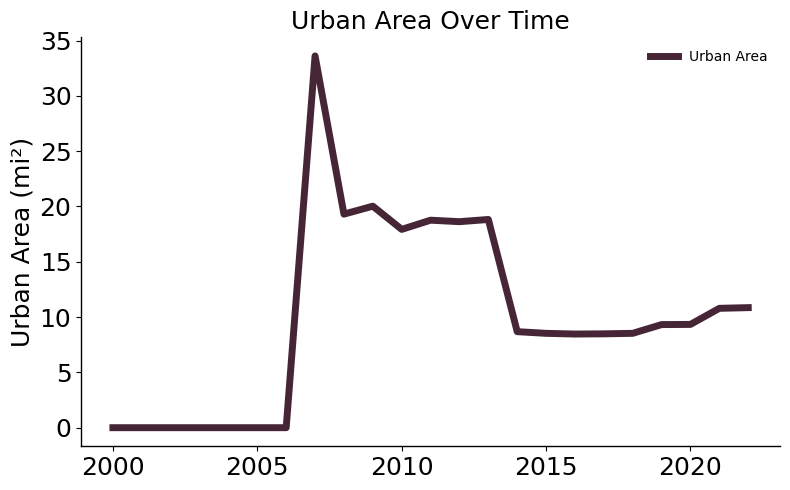

In [34]:
# Load the CSV data
data = pd.read_csv('/content/gdrive/MyDrive/Data/Mason Water Budget/data_output/land_use/mason_cdl.csv')

# Define the custom theme function
def theme_cust(ax):
    ax.spines['top'].set_visible(False)       # Remove the top spine
    ax.spines['right'].set_visible(False)     # Remove the right spine
    ax.spines['left'].set_linewidth(1)        # Set the left spine thickness
    ax.spines['bottom'].set_linewidth(1)      # Set the bottom spine thickness
    ax.tick_params(axis='both', colors='black')  # Set tick colors
    ax.xaxis.label.set_color('black')         # Set x-axis label color
    ax.yaxis.label.set_color('black')         # Set y-axis label color
    return ax

# Extract relevant columns
years = data['Year']
urban_area = data['Urban Area (mi²)']  # Replace with the correct column name if different

# Create the plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(years, urban_area, color='#462636', linewidth=5, label='Urban Area')
ax.scatter(years, urban_area, color='#462636', s=3)  # Add points to the line

# Customize the plot
ax.set_title("Urban Area Over Time", fontsize=18)
ax.set_xlabel("", fontsize=11)
ax.set_ylabel("Urban Area (mi²)", fontsize=18)
theme_cust(ax)  # Apply the custom theme
ax.legend(frameon=False)
ax.tick_params(axis='both', labelsize=18)

# Show the plot
plt.tight_layout()
plt.show()

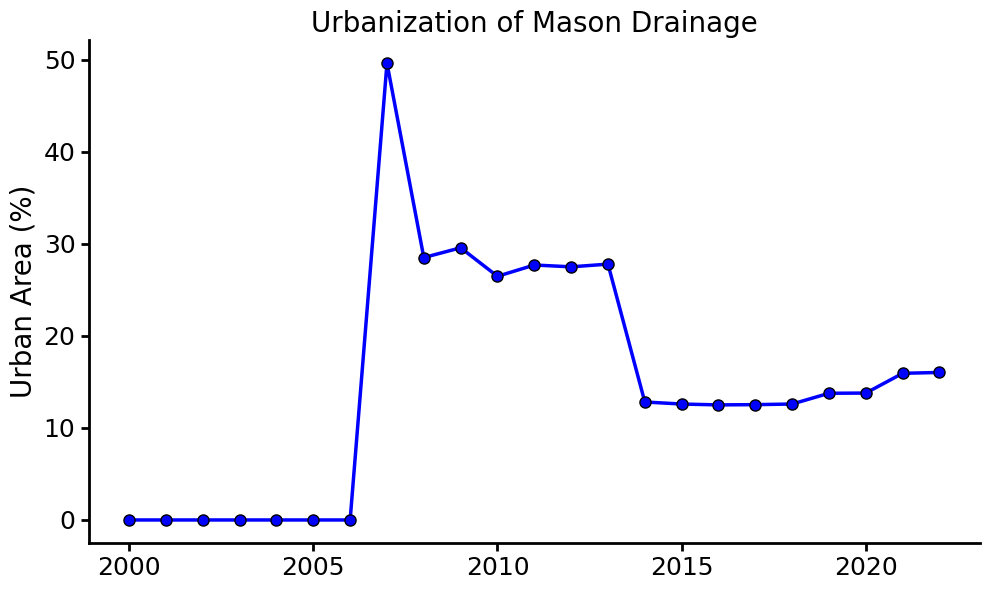

In [24]:
# Load the CSV data
data = pd.read_csv('/content/gdrive/MyDrive/Data/Mason Water Budget/data_output/land_use/mason_cdl.csv')

# Define a custom theme similar to R's theme_cust
def theme_cust(ax):
    ax.spines['top'].set_visible(False)       # Remove the top spine
    ax.spines['right'].set_visible(False)     # Remove the right spine
    ax.spines['left'].set_linewidth(2)        # Set the left spine thickness
    ax.spines['bottom'].set_linewidth(2)      # Set the bottom spine thickness
    ax.tick_params(axis='both', colors='black', width=2, length=6)  # Set tick colors and size
    ax.xaxis.label.set_color('black')         # Set x-axis label color
    ax.yaxis.label.set_color('black')         # Set y-axis label color
    return ax

# Create the plot
plt.figure(figsize=(10, 6))

# Scatter plot
plt.plot(
    data['Year'],
    data['Urban Percent'],
    color='blue',        # Darker line color
    linewidth=2.5,        # Thicker line
    marker='o',           # Add markers
    markersize=8,         # Larger markers
    markerfacecolor='blue',  # Blue markers
    markeredgecolor='black'  # Darker marker outline
)

# Customize the plot
ax = plt.gca()  # Get the current axis
ax.set_title("Urbanization of Mason Drainage", fontsize=20)
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("Urban Area (%)", fontsize=20)
ax.tick_params(axis='both', labelsize=18)

# Apply custom theme
theme_cust(ax)

# Remove the grid
plt.grid(False)

# Show the plot
plt.tight_layout()
plt.show()

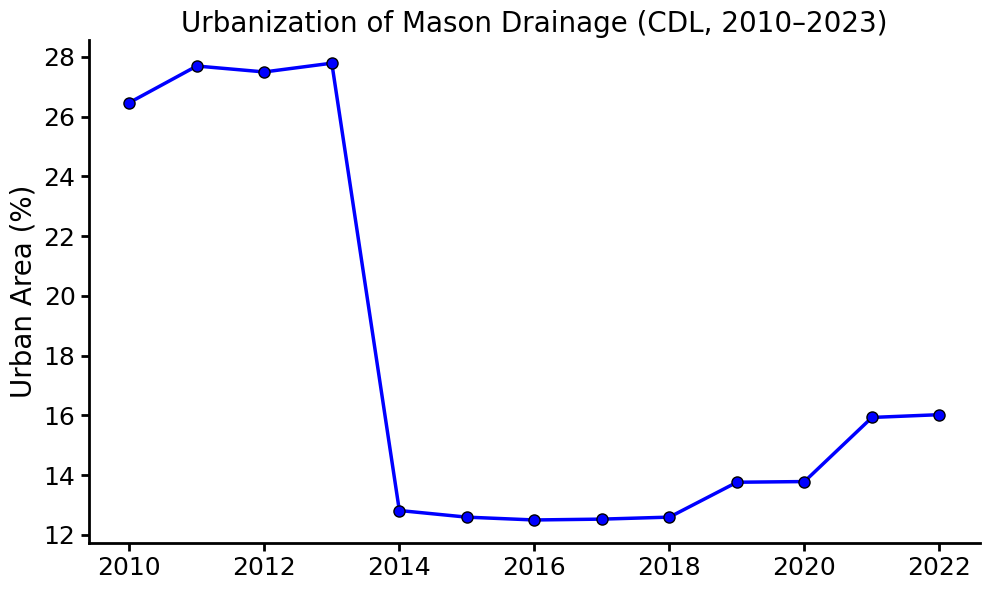

In [67]:
# Load the CSV data
data = pd.read_csv('/content/gdrive/MyDrive/Data/Mason Water Budget/data_output/land_use/mason_cdl.csv')

# Replace the 'Total Area (mi²)' column with the shapefile area
data['Total Area (mi²)'] = shapefile_area_mi2

# Recalculate the percentage of the urban area
data['Urban Percent'] = (data['Urban Area (mi²)'] / data['Total Area (mi²)']) * 100

# Filter the data for years 2010 to 2023
filtered_data = data[(data['Year'] >= 2010) & (data['Year'] <= 2024)]

# Define a custom theme similar to R's theme_cust
def theme_cust(ax):
    ax.spines['top'].set_visible(False)       # Remove the top spine
    ax.spines['right'].set_visible(False)     # Remove the right spine
    ax.spines['left'].set_linewidth(2)        # Set the left spine thickness
    ax.spines['bottom'].set_linewidth(2)      # Set the bottom spine thickness
    ax.tick_params(axis='both', colors='black', width=2, length=6)  # Set tick colors and size
    ax.xaxis.label.set_color('black')         # Set x-axis label color
    ax.yaxis.label.set_color('black')         # Set y-axis label color
    return ax

# Create the plot
plt.figure(figsize=(10, 6))

# Scatter plot
plt.plot(
    filtered_data['Year'],
    filtered_data['Urban Percent'],
    color='blue',        # Darker line color
    linewidth=2.5,        # Thicker line
    marker='o',           # Add markers
    markersize=8,         # Larger markers
    markerfacecolor='blue',  # Blue markers
    markeredgecolor='black'  # Darker marker outline
)

# Customize the plot
ax = plt.gca()  # Get the current axis
ax.set_title("Urbanization of Mason Drainage (CDL, 2010–2023)", fontsize=20)
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("Urban Area (%)", fontsize=20)
ax.tick_params(axis='both', labelsize=18)

# Apply custom theme
theme_cust(ax)

# Remove the grid
plt.grid(False)

# Show the plot
plt.tight_layout()
plt.show()

## Urban Change from LCMAP 1987 to 2021

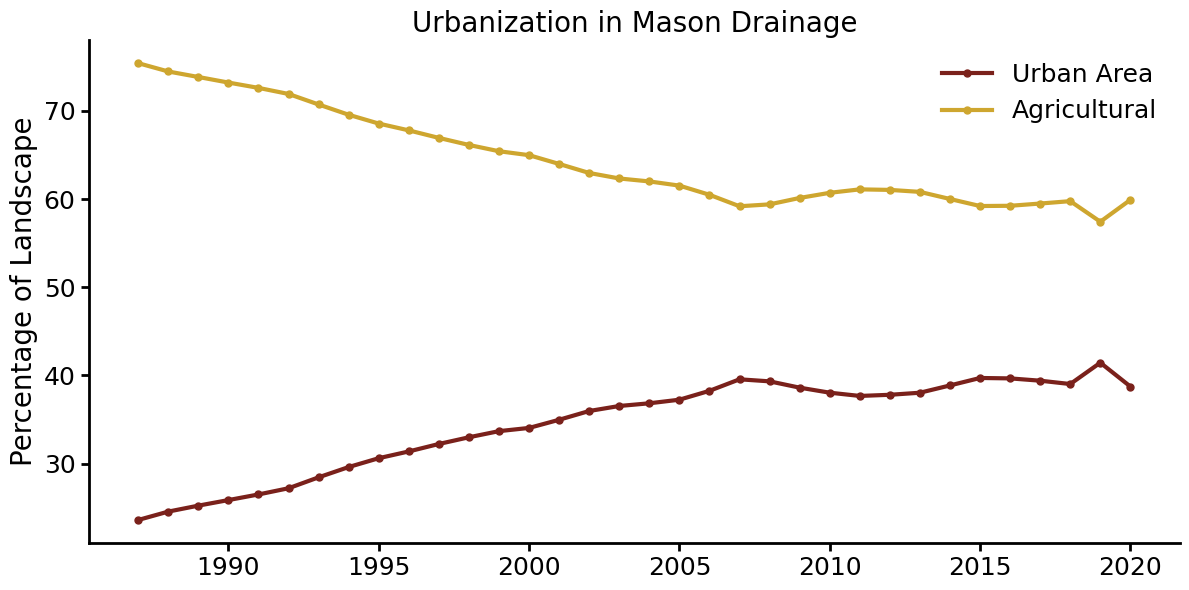

In [75]:
file = pd.read_csv('/content/gdrive/MyDrive/Data/Drains_Lower_Boise_River/data_output/landcover_calculations_out/final_metrics/Mason Creek.csv')

# Extract relevant columns
years = file['dates']
urban = file['class1_urban']
crops = file['class2_crops']

# Define the custom theme
def theme_cust(ax):
    ax.spines['top'].set_visible(False)       # Remove the top spine
    ax.spines['right'].set_visible(False)     # Remove the right spine
    ax.spines['left'].set_linewidth(2)        # Set the left spine thickness
    ax.spines['bottom'].set_linewidth(2)      # Set the bottom spine thickness
    ax.tick_params(axis='both', colors='black', width=2, length=6)  # Set tick colors and size
    ax.xaxis.label.set_color('black')         # Set x-axis label color
    ax.yaxis.label.set_color('black')         # Set y-axis label color
    return ax

# Create the plot
plt.figure(figsize=(12, 6))

# Plot urban class
plt.plot(
    years,
    urban,
    label='Urban Area',
    color='#7A211B',
    linewidth=3,
    marker='o',
    markersize=5
)

# Plot crops class
plt.plot(
    years,
    crops,
    label='Agricultural',
    color='#CEA62F',
    linewidth=3,
    marker='o',
    markersize=5
)

# Customize the plot
ax = plt.gca()  # Get the current axis
ax.set_title("Urbanization in Mason Drainage", fontsize=20)
ax.set_xlabel("", fontsize=20)
ax.set_ylabel("Percentage of Landscape", fontsize=20)
ax.tick_params(axis='both', labelsize=18)

# Apply the custom theme
theme_cust(ax)

# Add legend
plt.legend(frameon=False, fontsize=18)

# Show the plot
plt.tight_layout()
plt.show()

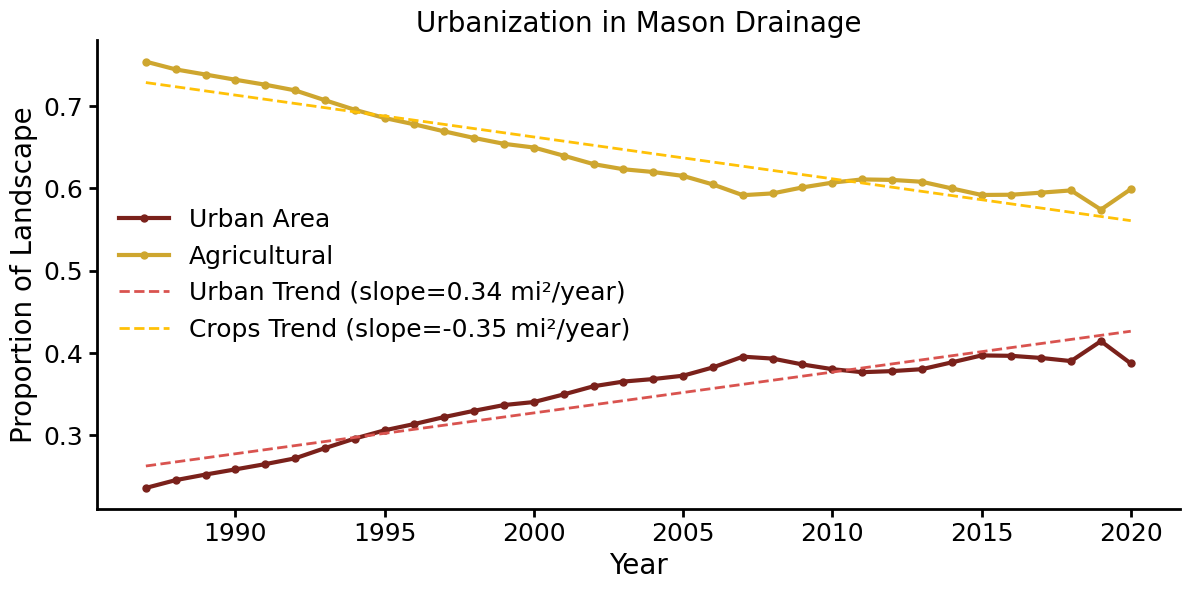

In [81]:
# Load the file
file_path = '/content/gdrive/MyDrive/Data/Drains_Lower_Boise_River/data_output/landcover_calculations_out/final_metrics/Mason Creek.csv'
file = pd.read_csv(file_path)

# Extract relevant columns and adjust for mislabeled percentages
years = file['dates']
urban = file['class1_urban'] / 100  # Convert to proportions
crops = file['class2_crops'] / 100  # Convert to proportions

# Convert years to numeric for trend line calculations
years_numeric = pd.to_numeric(years, errors='coerce')

# Define the total area in square miles
total_area = 68

# Define the custom theme
def theme_cust(ax):
    ax.spines['top'].set_visible(False)       # Remove the top spine
    ax.spines['right'].set_visible(False)     # Remove the right spine
    ax.spines['left'].set_linewidth(2)        # Set the left spine thickness
    ax.spines['bottom'].set_linewidth(2)      # Set the bottom spine thickness
    ax.tick_params(axis='both', colors='black', width=2, length=6)  # Set tick colors and size
    ax.xaxis.label.set_color('black')         # Set x-axis label color
    ax.yaxis.label.set_color('black')         # Set y-axis label color
    return ax

# Create the plot
plt.figure(figsize=(12, 6))

# Plot urban class
plt.plot(
    years,
    urban,
    label='Urban Area',
    color='#7A211B',
    linewidth=3,
    marker='o',
    markersize=5
)

# Plot crops class
plt.plot(
    years,
    crops,
    label='Agricultural',
    color='#CEA62F',
    linewidth=3,
    marker='o',
    markersize=5
)

# Add trendline for urban class
urban_slope, urban_intercept, _, _, _ = linregress(years_numeric, urban)
urban_trend = urban_slope * years_numeric + urban_intercept
urban_slope_mi2 = urban_slope * total_area  # Convert slope to mi²/year
plt.plot(
    years,
    urban_trend,
    label=f'Urban Trend (slope={urban_slope_mi2:.2f} mi²/year)',
    color='#D9534F',
    linestyle='--',
    linewidth=2
)

# Add trendline for crops class
crops_slope, crops_intercept, _, _, _ = linregress(years_numeric, crops)
crops_trend = crops_slope * years_numeric + crops_intercept
crops_slope_mi2 = crops_slope * total_area  # Convert slope to mi²/year
plt.plot(
    years,
    crops_trend,
    label=f'Crops Trend (slope={crops_slope_mi2:.2f} mi²/year)',
    color='#FFC107',
    linestyle='--',
    linewidth=2
)

# Customize the plot
ax = plt.gca()  # Get the current axis
ax.set_title("Urbanization in Mason Drainage", fontsize=20)
ax.set_xlabel("Year", fontsize=20)
ax.set_ylabel("Proportion of Landscape", fontsize=20)
ax.tick_params(axis='both', labelsize=18)

# Apply the custom theme
theme_cust(ax)

# Add legend
plt.legend(frameon=False, fontsize=18)

# Show the plot
plt.tight_layout()
plt.show()